In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import random
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

# Extract Data

In [3]:
## unzipping dataset

files = zf.ZipFile("dataset-sampah.zip",'r')
files.extractall()
files.close()

In [4]:
os.listdir(os.path.join(os.getcwd(),"dataset-sampah"))

['paper', 'metal', 'cardboard', 'trash', 'plastic']

In [5]:
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

In [6]:
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)

In [7]:
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [8]:
##sepa

## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-sampah',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [9]:
# path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/Users/nadhifahhanan/Documents/SEMESTER-6/Tugas Akhir/data')

In [10]:
from fastai.vision import *
from fastai.metrics import error_rate

In [11]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16, num_workers=0)

In [12]:
data

ImageDataBunch;

Train: LabelList (1012 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /Users/nadhifahhanan/Documents/SEMESTER-6/Tugas Akhir/data;

Valid: LabelList (505 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /Users/nadhifahhanan/Documents/SEMESTER-6/Tugas Akhir/data;

Test: LabelList (509 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /Users/nadhifahhanan/Documents/SEMESTER-6/Tugas Akhir/data

In [13]:
data.classes

['cardboard', 'metal', 'paper', 'plastic', 'trash']

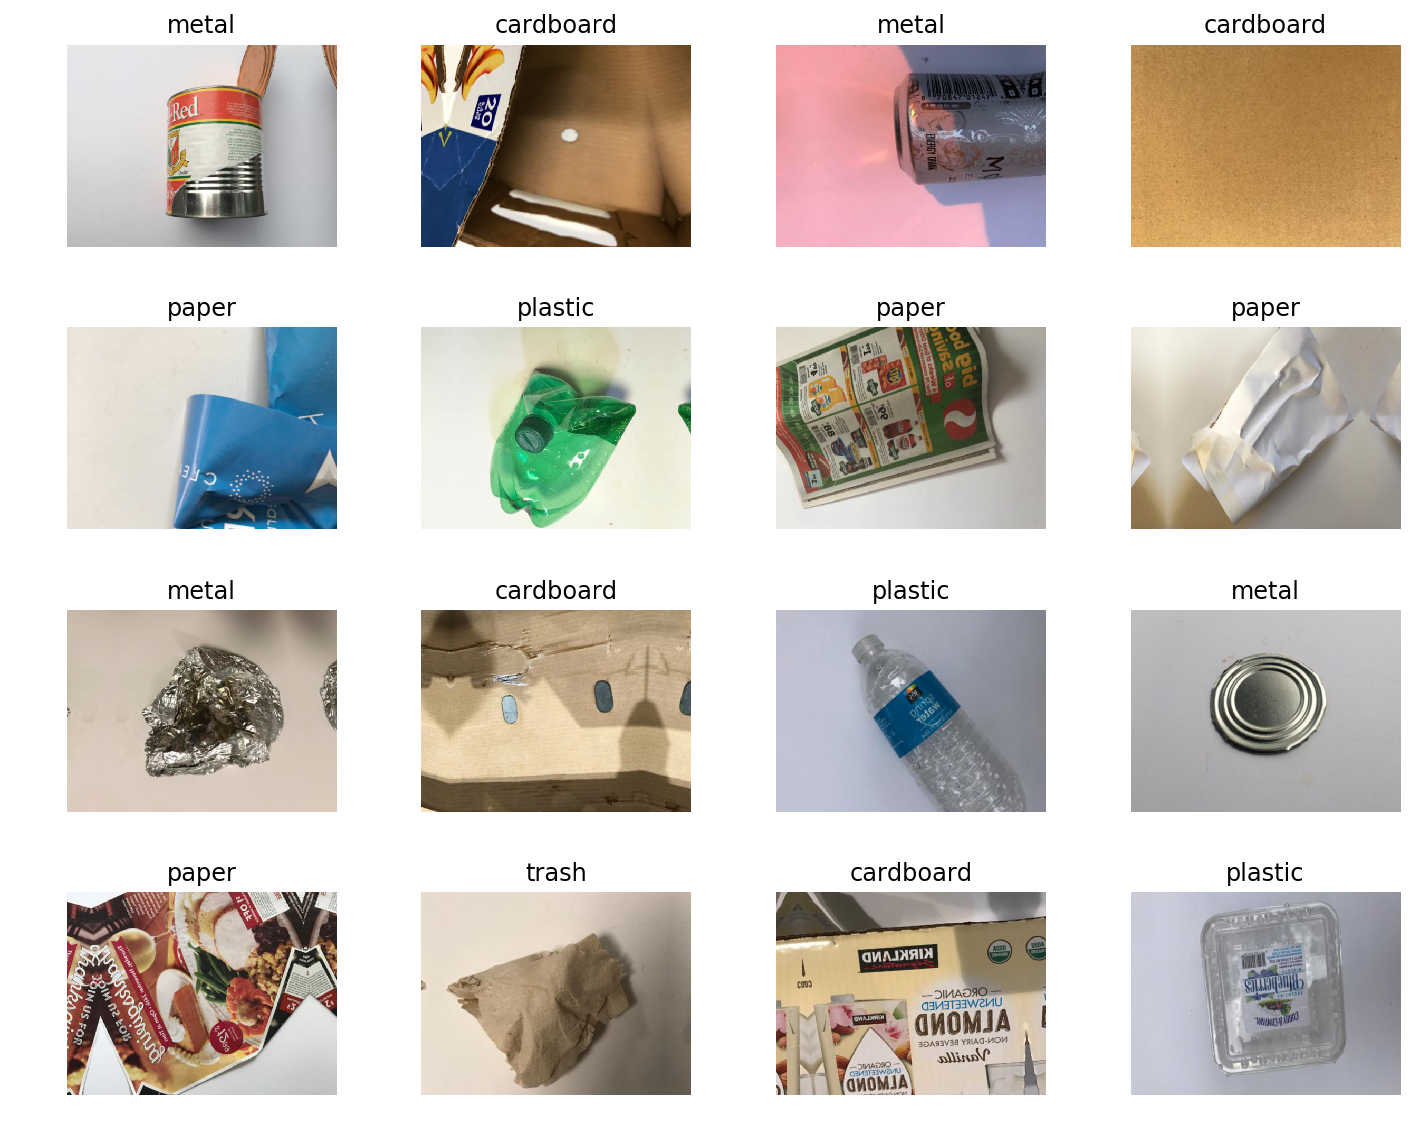

In [14]:
data.show_batch(rows=4,figsize=(10,8))

# Training

In [15]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

learning rate

In [17]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.13E-03


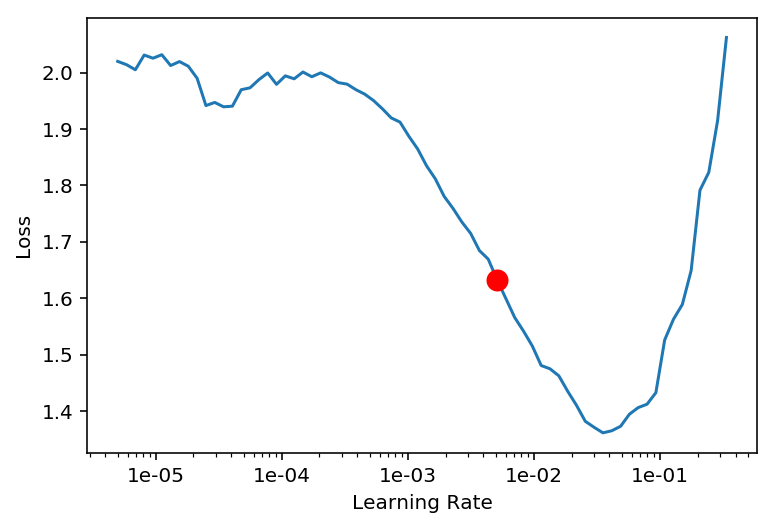

In [18]:
learn.recorder.plot(suggestion=True)

In [19]:
learn.fit_one_cycle(5,max_lr=5.13E-03)

epoch,train_loss,valid_loss,error_rate,time
0,0.910965,0.449950,0.150495,16:08
1,0.688116,0.495210,0.194059,15:22
2,0.582458,0.349213,0.118812,15:18
3,0.413343,0.254276,0.095050,15:28
4,0.333300,0.253381,0.089109,14:54


In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

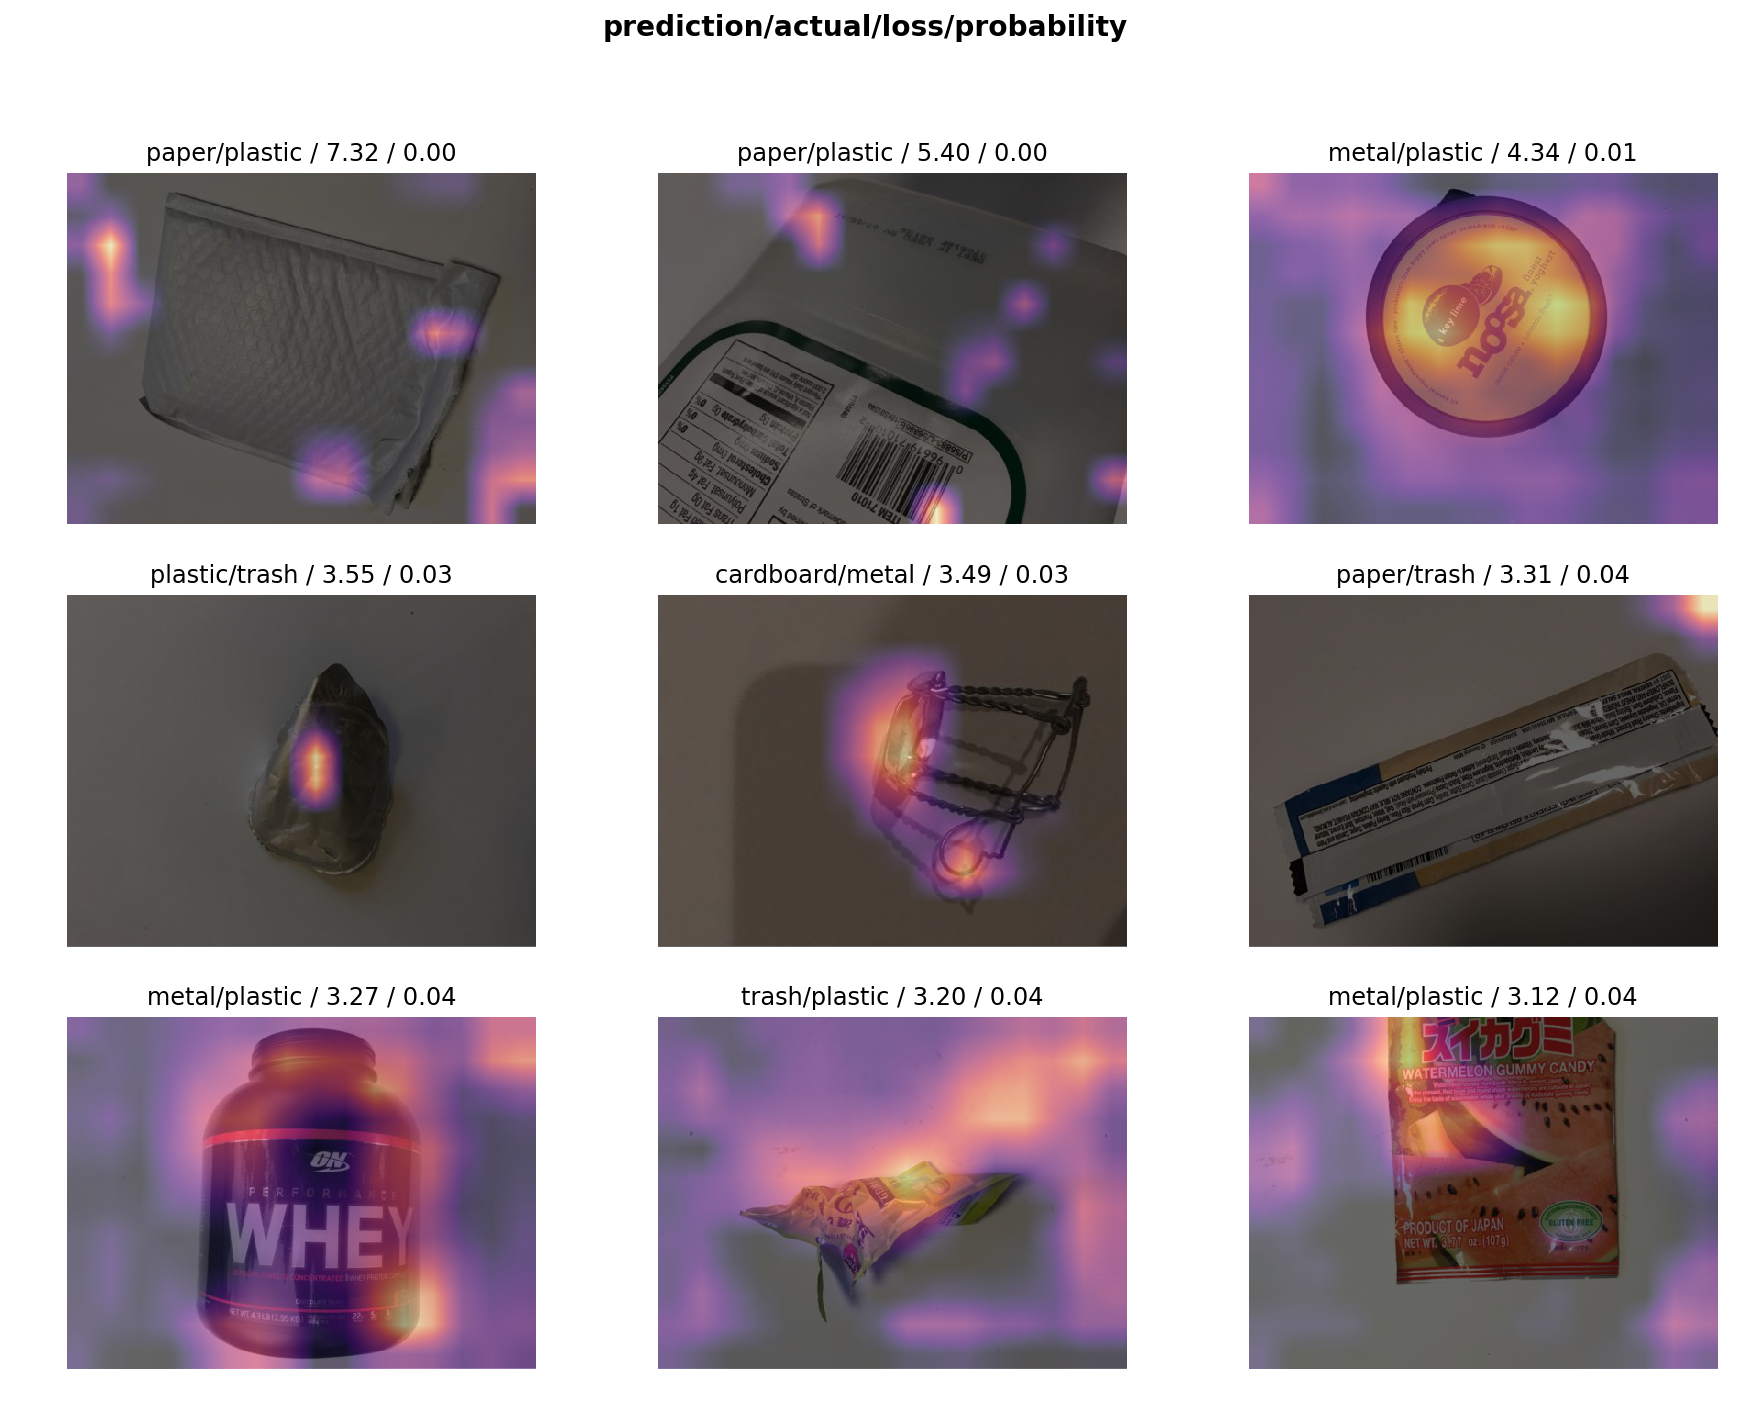

In [21]:
interp.plot_top_losses(9, largest=True, figsize=(15,11))

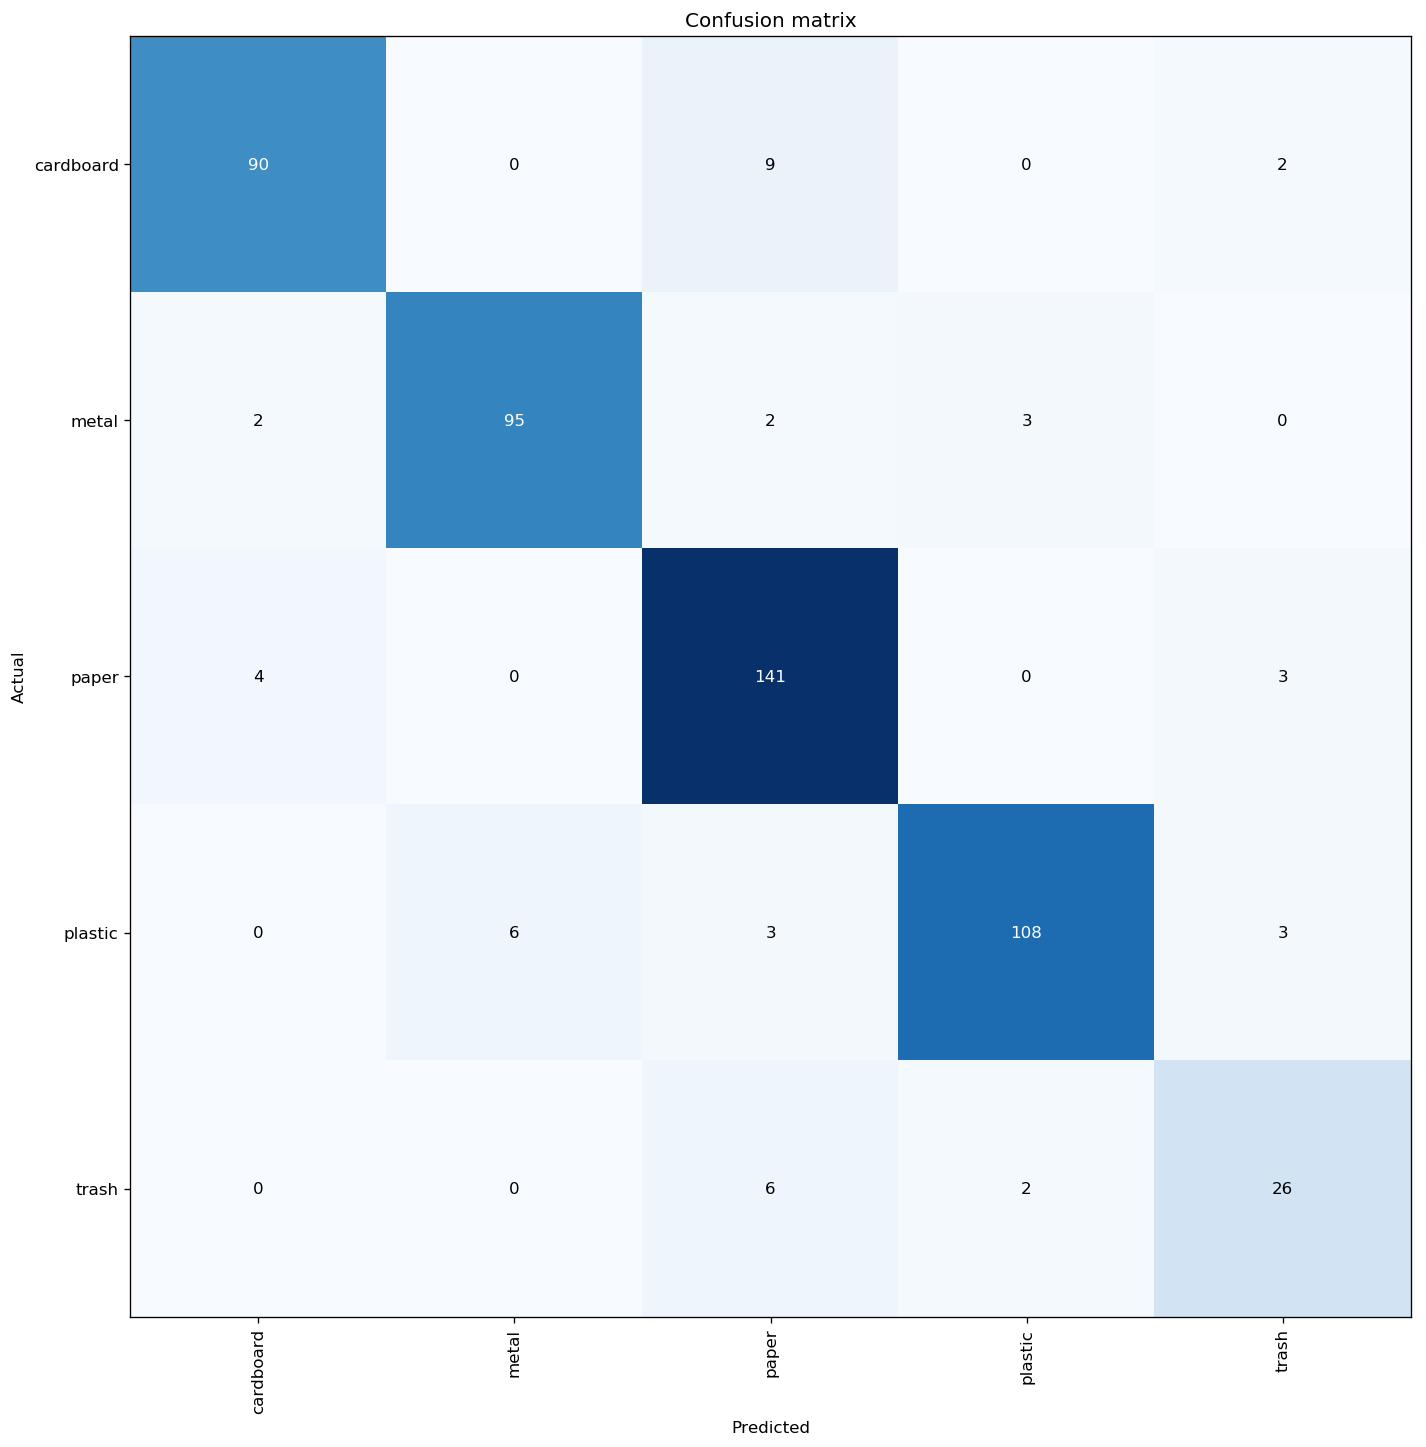

In [22]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# new data predictions

In [23]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [24]:
print(preds[0].shape)
preds[0]

torch.Size([509, 5])


tensor([[9.7513e-01, 5.8729e-03, 6.5108e-03, 1.8542e-03, 1.0633e-02],
        [9.7749e-05, 9.9845e-01, 1.3275e-04, 1.2239e-03, 9.9738e-05],
        [4.2036e-05, 5.6890e-04, 7.3623e-07, 9.9932e-01, 6.6177e-05],
        ...,
        [9.3025e-03, 2.6387e-05, 9.9015e-01, 2.1764e-04, 3.0239e-04],
        [1.5592e-02, 1.2758e-04, 9.8062e-01, 1.6692e-03, 1.9870e-03],
        [1.1366e-03, 1.2007e-02, 2.5474e-05, 9.8512e-01, 1.7110e-03]])

In [25]:
data.classes

['cardboard', 'metal', 'paper', 'plastic', 'trash']

In [26]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [27]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [28]:
yhat

['cardboard',
 'metal',
 'plastic',
 'trash',
 'plastic',
 'plastic',
 'paper',
 'paper',
 'cardboard',
 'paper',
 'cardboard',
 'cardboard',
 'paper',
 'plastic',
 'metal',
 'cardboard',
 'plastic',
 'metal',
 'paper',
 'cardboard',
 'cardboard',
 'plastic',
 'paper',
 'cardboard',
 'paper',
 'paper',
 'paper',
 'metal',
 'plastic',
 'metal',
 'cardboard',
 'plastic',
 'metal',
 'plastic',
 'plastic',
 'plastic',
 'paper',
 'metal',
 'paper',
 'cardboard',
 'paper',
 'paper',
 'paper',
 'cardboard',
 'paper',
 'plastic',
 'cardboard',
 'metal',
 'cardboard',
 'paper',
 'cardboard',
 'cardboard',
 'metal',
 'plastic',
 'cardboard',
 'plastic',
 'cardboard',
 'paper',
 'paper',
 'paper',
 'paper',
 'metal',
 'plastic',
 'trash',
 'plastic',
 'plastic',
 'metal',
 'metal',
 'plastic',
 'metal',
 'plastic',
 'metal',
 'metal',
 'trash',
 'paper',
 'paper',
 'paper',
 'paper',
 'cardboard',
 'cardboard',
 'cardboard',
 'plastic',
 'plastic',
 'plastic',
 'cardboard',
 'cardboard',
 'plasti

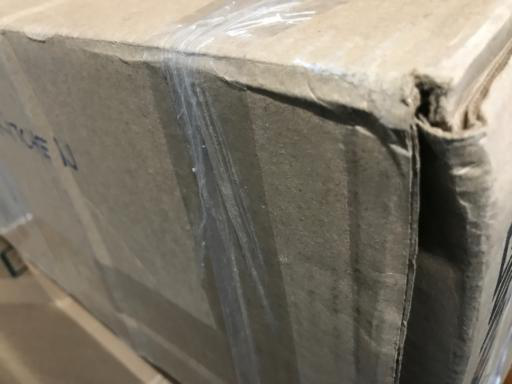

In [29]:
learn.data.test_ds[0][0]

In [30]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [31]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['cardboard', 'metal', 'plastic', 'trash', 'plastic']
['cardboard', 'metal', 'plastic', 'trash', 'plastic']


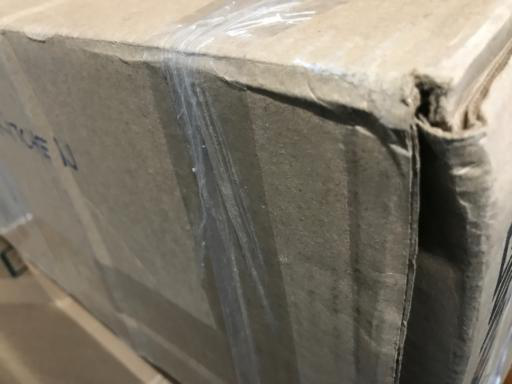

In [32]:
learn.data.test_ds[0][0]

In [33]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 96   2   2   1   0]
 [  2  95   1   2   3]
 [  2   0 143   0   4]
 [  0   1   1 116   3]
 [  1   3   8   3  20]]


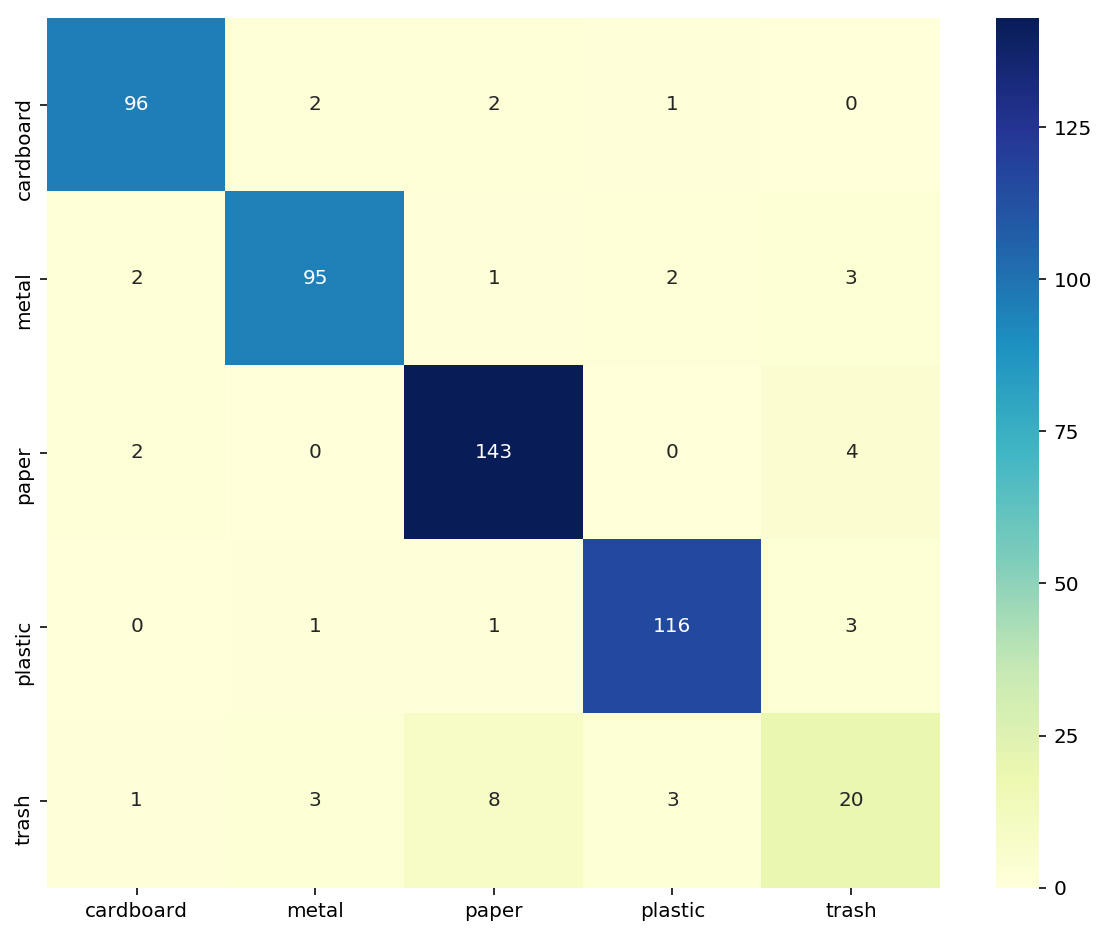

In [34]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [35]:
interp.most_confused(min_val=2)

[('cardboard', 'paper', 9),
 ('plastic', 'metal', 6),
 ('trash', 'paper', 6),
 ('paper', 'cardboard', 4),
 ('metal', 'plastic', 3),
 ('paper', 'trash', 3),
 ('plastic', 'paper', 3),
 ('plastic', 'trash', 3),
 ('cardboard', 'trash', 2),
 ('metal', 'cardboard', 2),
 ('metal', 'paper', 2),
 ('trash', 'plastic', 2)]

In [36]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [37]:
accuracy = correct/sum(sum(cm))
accuracy

0.9233791748526523